In [30]:
## This script computes VerbNet pairwise sentence similarities for Neuro Data (non-paired)
# Requires that sentences have already been parsed using VerbNet semantic roles, as performed by 'Calc_parse_GPT4.ipynb'.
# Run using base python 3.9
# James Fodor 2023

# load libraries
import numpy as np
import json
import random
import itertools
import sentence_embeds_processing as sep
import seaborn as sns
import matplotlib.pyplot as plt

# load file paths
with open("file_paths.json", "r") as file:
    file_paths_dict = json.load(file)

# set fixed params
role_weights_dict = {'Agent':2, 'Verb':3, 'Patient':2, 'Theme':2, 'Time':0.5, 'Manner':0.5, 'Location':0.5, 'Trajectory':0.5}
role_weights_list = np.array(list(role_weights_dict.values()))/11

# numpy print options
np.set_printoptions(precision=2, threshold=2000, linewidth=200, suppress=True, floatmode='fixed')
sns.set()

# define stop words
stop_words = np.loadtxt(file_paths_dict['stop_words_path'], dtype='str') # list of stop words

### Step 0: Load sentence dataset and parse

Load the dataset of sentences we want to compute VerbNet similarities for.

In [2]:
## Show available datasets, as specified in the sentence_embeds_processing module
pairs = True # specify if we are using paired data or list of sentences
if pairs==True:
    datasets = sep.available_pair_datasets
else:
    datasets = sep.available_nonpaired_datasets
for dataset in datasets.keys():
    print(dataset,datasets[dataset])

0 GS2011_processed
1 KS2013_processed
2 Fodor_pilot_2022
3 STS131_processed
4 SICK_relatedness
5 STSb_captions_test
6 STSb_forums_test
7 STSb_headlines_test
8 STSb_test
9 STS3k_all


In [ ]:
## Load sentence set (choose number from those printed above)
dataset = datasets[5]
sentences_dict = sep.load_set_of_sentences(dataset, file_paths_dict['data_pairs_path'], file_paths_dict['data_nonpaired_path'], pairs)
if pairs==False:
    full_dataset_name = sep.fix_sentence_dataset_name(dataset)
    full_dataset_name = sep.extract_text_between('^([^_]+)',full_dataset_name)[0] # remove 'neuro' from name
else:
    full_dataset_name=dataset
n = len(sentences_dict.keys()) # num sentences
print('\nloaded',dataset,'with',n,'sentences')

In [10]:
## load parse data for the dataset
parse_type = 'VerbNet' # choose parse type ('verbnet' or 'GPT4')
json_path = file_paths_dict['parses_path']+parse_type+' Parsing\\full_'+parse_type+'_pass_'+full_dataset_name+'_mod.json'
sentence_pair_parsed_dict = json.load(open(json_path)) # load verbnet parse data from json
print('parse type:',parse_type)
print('sentences parsed:',n)

parse type: VerbNet
sentences parsed: 2800


### Step 1: Produce file with set of parsed sentence pairs (only do once)

Produce a file with the VerbNet semantic role parse with all possible pairs of sentences. 
This is required because we need to compute the similarity between all pairs of sentences, which requires processing each pairwise comparison separately.

In [11]:
## Generate file with all pairs of sentences from a neuro dataset
sent_id_pairs = list(itertools.combinations(sentence_pair_parsed_dict.keys(), 2))
sentence_pair_parsed_dict_neuro = {}
i = 0
for sent_id_pair in sent_id_pairs:
    sent_1 = sentence_pair_parsed_dict[sent_id_pair[0]][0]
    sent_2 = sentence_pair_parsed_dict[sent_id_pair[1]][0]
    sentence_pair_parsed_dict_neuro[str(i)] = [sent_1,sent_2]
    i+=1
    
with open(json_path[0:-8]+"pairs.json", "w") as file:
    json.dump(sentence_pair_parsed_dict_neuro, file, indent=0)

### Step 2: Load pairwise parse data and embeddings model

Having produced a pairwise set of VerbNet semantic role parses in Step 1 above, we load this data for use in Step 3. Also need to load ConceptNet word embeddings.

In [ ]:
# Load pairwise parse data for the sentence set (file generated in step 1)
json_path = file_paths_dict['parses_path']+parse_type+' Parsing\\full_'+parse_type+'_pass_'+full_dataset_name+'_pairs.json'
sentence_pair_parsed_dict = json.load(open(json_path)) # load verbnet parse data from json
n = len(list(sentence_pair_parsed_dict.keys()))
print('parse type:',parse_type)
print('pairs loaded:',n)

In [15]:
## Load ConceptNet embeddings
model_address = file_paths_dict['path_root']+'\Word Embeddings\ConceptNet Embeddings\\numberbatch-en.txt'
conceptnet_embeds = sep.import_word_model(model_address)
print('loaded ConceptNet embeddings')

loaded ConceptNet embeddings


### Step 3: Compute Rolewise Similarities (only do once)

Compute the rolewise similarities of two sentences using the VerbNet semantic role parses. This is the key step of computation and is very slow - maybe an hour per 1000 pairs. Only do this once and save the results.

In [25]:
## Functions to compute VerbNet rolewise similarities 

# Define special dictionaries and lists of words
tag_alignment_dict = [('Location','Trajectory'), ('Theme','Patient'), ('Theme','Manner'), ('Manner','Trajectory'), ('Patient','Location'), ('Patient','Manner')]

# Split a list up into n equal sublists
def partition_list(list_in, n):
    random.shuffle(list_in)
    return [list_in[i::n] for i in range(n)]


# Try to print specific semantic role from sentence
def get_semant_ele(sentence,element):
    try:
        return(sentence[element])
    except KeyError:
        return('NONE')
    

# Load word weights to adjust similarities for word frequency
def load_word_weights():
    # Load each line of fine into list
    filename = file_paths_dict['sims_path']+'\Corpus Data\Lambda Corpus\lambada-vocab.txt'
    with open(filename, encoding='utf-8') as file:
        words_raw = [line.rstrip('\n').split('\t') for line in file]

    # convert to dictionary    
    word_count_dict = {}
    for word in words_raw:
        word_count_dict[word[0]] = int(word[1])
        
    # compute word weights
    n = word_count_dict['<s>'] # total number of sentences in corpus
    word_weights = {} # store weights for each word
    for word in word_count_dict.keys():
        word_weights[word]= -np.log2(word_count_dict[word]/n)/10
    return word_weights


# Compute embedding for phrases from the verbnet parse using conceptnet
def phrase_embed(pair_id, phrase):
    # Split phrase into words and define storage
    word_list = sep.tokenise_sentence(phrase, stop_words)
    word_list = sep.replace_tricky_tokens(word_list)
    embed_length = len(conceptnet_embeds['man'])
    embeds = np.empty((0,embed_length), float)
    
    # Get word embeddings for each word in phrase
    for word in word_list:
        try:
            embeds = np.vstack([embeds,conceptnet_embeds[word.lower()]])
        except KeyError:
            print(pair_id,'couldn\'t find',word)
            continue # ignore words we can't find
    
    # Save final phrase embeddings
    if len(np.ndarray.flatten(embeds)) > embed_length: # deal with phrases with multiple embeddings
        phrase_embedding = np.mean(embeds, axis=0) # average over all saved embeddings
    else:
        try:
            phrase_embedding = embeds[0] # use embeddings for single word
        except IndexError:
            phrase_embedding = np.zeros(embed_length) # return array of zeros if no words in phrase found
    
    return(phrase_embedding)


# Compute the weighted phrase similiarity for matching pair of phrases
def calc_weighted_phrase_sim(pair_id, phrase_1, phrase_2, weighting):
    phrase_embed_1 = phrase_embed(pair_id, phrase_1)
    phrase_embed_2 = phrase_embed(pair_id, phrase_2)
    try:
        word_weights = load_word_weights()
        phrase_1_weight = max(word_weights[word] for word in phrase_1.split(' '))
        phrase_2_weight = max(word_weights[word] for word in phrase_2.split(' '))
        sim = sep.cosine_sim(phrase_embed_1,phrase_embed_2) # compute phrase cosine similarity
        if weighting==True:
            return max(phrase_1_weight,phrase_2_weight)*sim # weight sim by phrase sims to account for word rarity
        else:
            return float(sim) # version without word frequency weighting
    except KeyError:
        sim = 0 # return zero if can't find word weights
        return float(sim)


# Return the count of the number of sentences containing the relevant role over the entire dictionary
def get_role_counts(sentence_pair_parsed_dict, sent_id):
    all_tags = {}
    for sent_pair in sentence_pair_parsed_dict.values():
        for tag in list(sent_pair[sent_id].keys()):
            try:
                all_tags[tag]+=1
            except KeyError:
                all_tags[tag]=1
                
    return(all_tags)

# Function to convert role-wise dictionary sim storage into role-wise list storage
def dict_sim_to_list(role_weights_dict, sim_storage_dict):
    sim_storage_dict_full = {}
    for role in role_weights_dict.keys():
        try:
            sim_storage_dict_full[role] = sim_storage_dict[role]
        except KeyError:
            sim_storage_dict_full[role] = 0
    sim_storage_list = list(sim_storage_dict_full.values())
    
    return(sim_storage_list)


def calc_rolewise_sims(pair_id, role_alignment_dict):

    # Get the sentence pair to compute similarity for
    sentence_pair = sentence_pair_parsed_dict[pair_id]
    sent_1_parsed = sentence_pair[0]
    sent_2_parsed = sentence_pair[1]
    
    # role sims storage dict
    role_sim_storage = {}

    for role in sent_1_parsed.keys():
        
        # Neither sentence has the role
        if sent_1_parsed[role]=='NONE' and sent_2_parsed[role]=='NONE':
            role_sim_storage[role] = np.NaN
            
        # Both sentences have the role
        elif sent_1_parsed[role]!='NONE' and sent_2_parsed[role]!='NONE':
            phrase_1 = sent_1_parsed[role].lower()
            phrase_2 = sent_2_parsed[role].lower()
            role_sim_storage[role] = round(calc_weighted_phrase_sim(pair_id, phrase_1, phrase_2, weighting=False),4)
            
        # If one sentence has the role but the other does not
        else:
            role_sim_storage[role] = 0
            
        # Match related but distinct roles when there is no direct match
        for role_match_1,role_match_2 in role_alignment_dict:
            if (sent_1_parsed[role_match_1]!='NONE' and sent_1_parsed[role_match_2]=='NONE') and (sent_2_parsed[role_match_1]=='NONE' and sent_2_parsed[role_match_2]!='NONE'):
                phrase_1 = sent_1_parsed[role_match_1].lower()
                phrase_2 = sent_2_parsed[role_match_2].lower()
                role_sim_storage[role_match_1] = round(calc_weighted_phrase_sim(pair_id, phrase_1, phrase_2, weighting=False),4)
                role_sim_storage[role_match_2] = np.NaN
                
    return role_sim_storage

In [17]:
## Compute role-wise sentence similarities using VerbNet parses

# dictionary of pairs of semantic roles to align if no direct matches are present
role_alignment_dict = [('Location','Trajectory'), ('Trajectory','Location'), ('Theme','Patient'), ('Patient','Theme'), ('Manner','Trajectory'), ('Trajectory','Manner')]

# initialise storage 
all_role_sim_storage = {}
all_sim_storage_list = []

# loop over all sentence pairs to compute rolewise similarities (this takes about 1.4s per sentence pair)
for pair_id in list(sentence_pair_parsed_dict.keys()):
    
    # Store in dictionary with all sentence pairs
    all_role_sim_storage[pair_id] = calc_rolewise_sims(pair_id, role_alignment_dict)

    # Convert dictionary storage of rolewise sims into list and store
    sim_storage_list = dict_sim_to_list(role_weights_dict,all_role_sim_storage[pair_id])
    all_sim_storage_list.append(sim_storage_list)
    
with open('full_GPT4_pass_'+full_dataset_name+"_rolewise_sims.json", "w") as file:
    json.dump(all_role_sim_storage, file, indent=0)

0 couldn't find 11th
0 couldn't find 12th
0 couldn't find 22
0 couldn't find 2008
2 couldn't find 35
3 couldn't find 11th
3 couldn't find 12th
4 couldn't find 11th
4 couldn't find 12th
5 couldn't find 2008
6 couldn't find 11th
6 couldn't find 12th
6 couldn't find 2008
7 couldn't find 2008
8 couldn't find 11th
8 couldn't find 12th
10 couldn't find 2008
13 couldn't find 11th
13 couldn't find 12th
15 couldn't find 11th
15 couldn't find 12th
16 couldn't find 2008
19 couldn't find 11th
19 couldn't find 12th
20 couldn't find 11th
20 couldn't find 12th
20 couldn't find 2008
21 couldn't find 11th
21 couldn't find 12th
24 couldn't find 2008
25 couldn't find 11th
25 couldn't find 12th
25 couldn't find 2008
27 couldn't find 2008
30 couldn't find 11th
30 couldn't find 12th
30 couldn't find 2008
32 couldn't find 2008
33 couldn't find 11th
33 couldn't find 12th
34 couldn't find 11th
34 couldn't find 12th
35 couldn't find 11th
35 couldn't find 12th
36 couldn't find 11th
36 couldn't find 12th
37 could

### Step 4: Compute overall VerbNet Similarities

In [41]:
## Load stored rolewise sims into list

# Load rolewise weights
json_rolewise_path = file_paths_dict['parses_path']+parse_type+' Parsing\\full_'+parse_type+'_pass_'+full_dataset_name+'_rolewise_similarities.json'
with open(json_rolewise_path, "r") as file:
    all_role_sim_storage = json.load(file)
    
# loop over all sentence pairs to load rolewise similarities
all_sim_storage_list = []
for pair_id in list(sentence_pair_parsed_dict.keys()):
    
    # Convert dictionary storage of rolewise sims into list and store
    sim_storage_list = dict_sim_to_list(role_weights_dict,all_role_sim_storage['conceptnet'][pair_id])
    all_sim_storage_list.append(sim_storage_list)

In [43]:
## Compute overall VerbNet similarity

# Compute basic version of VerbNet-based similarities with the same normalisation applied to each sentence pair
all_sims_storage_np = np.array(all_sim_storage_list) 
role_weights_array = np.array(list(role_weights_dict.values())) # get role weights
all_sim_storage_list_nonan = np.ma.array(all_sims_storage_np, mask=np.isnan(all_sims_storage_np)) # ignore nan values
basic_similarities_non_norm = np.ma.dot(all_sim_storage_list_nonan, role_weights_array)
basic_similarities = basic_similarities_non_norm/np.sum(list(role_weights_dict.values())) # divide by total sum of weights

# Compute normalised VerbNet-based similarities, with each sentence normalised by total sentence weight length
rolewise_weights_masked = []
normalised_similarities = []
i = 0
for pair_mask in all_sim_storage_list_nonan.mask:
    role_weights_array_masked = role_weights_array[~pair_mask] # need to invert the mask for the roles we want to keep
    total_length = np.sum(role_weights_array_masked) # get total weighted length of each sentence
    normalised_similarities.append(basic_similarities_non_norm[i]/total_length) # normalise weights by total weight length
    i+=1

In [46]:
## Save results
save_file_name = full_dataset_name+'_'+parse_type+'_fixedparms_basic_similarities.txt'
np.savetxt(save_file_name, basic_similarities, fmt='%f')

save_file_name = full_dataset_name+'_'+parse_type+'_fixedparms_norm_similarities.txt'
np.savetxt(save_file_name, normalised_similarities, fmt='%f')

### Step 5: Evaluate VerbNet Similarities

Plot a histograph of VerbNet rolewise similarities for evaluation of the distribution.

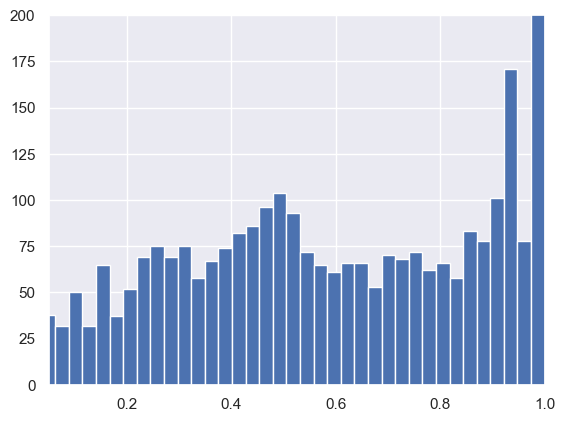

In [47]:
## Plot histogram of basic similarities
sns.set()
# plt.hist(basic_similarities.data, bins=40)
plt.hist(normalised_similarities, bins=40)
plt.xlim(0.05,1)
plt.ylim(0,200)
plt.show()